# Team Members: Jaden Phan, Sarah Morrison

Dataset: https://www.kaggle.com/datasets/tunguz/nba-forecasts



# Introduction:
The dataset we chose to use is an nba elo dataset. For the purposes of this project, elo is a score that describes a team's overall performance, measured by its deviation from 1300.

### Dataset Description
There are two tables provided in this dataset.
1. nba_elo.csv: contains game-by-game "elo" ratings and forecasts back to 1946
2. nba_elo_latest.csv: containts game-by-game "elo" ratings and forecasts for only the latest season.

Both datasets contain the same 24 column attributes. Here are the most important attributes to our study:
* **date**: yyyy-mm-dd of the game
* **season**: yyyy of season
* **elo1_pre**: each team starts the season with a rating of 1300. After every win or loss, they gain or lose elo based on their opponents relative score and game performance.
* **elo_prob**: analyst predicted chance of team winning
* **elo_post**: rating of each team after the result of the game
* **score**: score of the game for each team for each game

### We want to predict the winner of the games in the 2021 season
To do this, we will be leveraging the data from nba_elo.csv which contains game-by-game data that dates back to 1946. By training the classifier on over 60 years of past games, we hope it will be able to predict the winners of the games in nba_elo_latest.csv, this dataset contains the same game-by-game data but only for the 2020-2021 season.

* nba_elo.csv will be used to train the classifiers
* nba_elo_latest.csv will be used to test the classifiers

### Implementation/Technical Merit
* This dataset lacks documentation so we will need to spend some time understanding each attribute as well as deciding units for numerical values.
* There are some attributes with obscure names that we will need to understand as well.
* About 50% of the attributes have a majority of NULL values so we will need to decide how to interpret and handle these missing values.
* Our dataset is about 71,000 instances of data, we will likely need to **randomly sample** or cut down the size of samples in-order to reduce computing time. That being said having such a large dataset allows us to have a large amount of diversity in our data regardless of how we split or sample.

### Potential Impact of Results

Teams:

This could be useful for the teams in terms of strategy and management. It could also help the teams manage their fan engagement and marketing for the upcoming season.

Fans:

For fans, this could be useful for betting. This could also be useful for fans for increased general interest in their team, or rival teams.

## Findings

We found that Naive Bayes was our highest performing classifier with an accuracy score of 65%. The other classifiers we tested scored within the 47% to 57% range. In general it is hard to predict which team will win a given matchup do to the natural unpredictability of sports.

### Import libraries

In [70]:
# some useful mysklearn package import statements and reloads
import importlib
import pandas as pd
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# uncomment once you paste your myclassifiers.py into mysklearn package
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import mysklearn.mysimplelinearregressor
importlib.reload(mysklearn.mysimplelinearregressor)
import mysklearn.mysimplelinearregressor as linear

train = MyPyTable().load_from_file('input_data/nba_elo.csv')
test = MyPyTable().load_from_file('input_data/nba_elo_latest.csv')



### Check for data leaks
Check training set for any data leaks. Any instances from the 2021 season should not be in the training set because that is the year we are predicting

In [71]:
importlib.reload(mysklearn.mypytable)
train.drop_duplicate_seasons(2021)

### Select Range of Seasons
We found that selecting more recent seasons to predict future seasons made the most sense. This is because things like rules, culture, rosters, and players change throughout time. So in order to keep the training as relevant as possible, we decided to train on data from 2010-2020.

In [72]:
importlib.reload(mysklearn.mypytable)

small_train = myutils.filter_by_season_range(train, 2010,2020)


## Create new column, this will be the class we are predicting
We want to predict the winner of games based on past data, so we will create a new column called "winner"
* winner = 1 when team 1 wins
* winner = 0 when team 2 wins

In [73]:
importlib.reload(mysklearn.myutils)

# First we will calculate the winners
train_winner = myutils.calculate_winners(small_train)
test_winner = myutils.calculate_winners(test)

# Next we add a new column to both test and train sets
small_train.add_column("winner", train_winner)
test.add_column("winner", test_winner)

## EDA - Visualizations

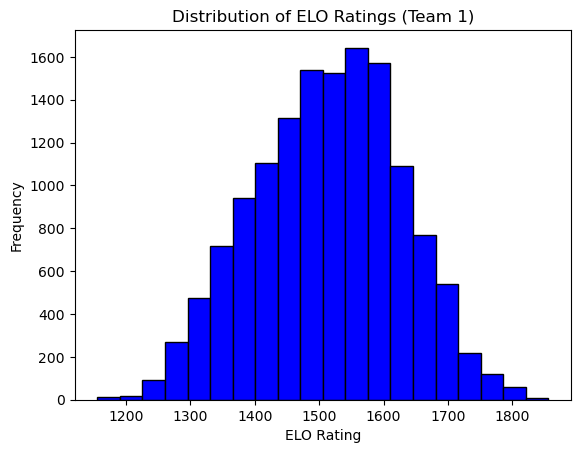

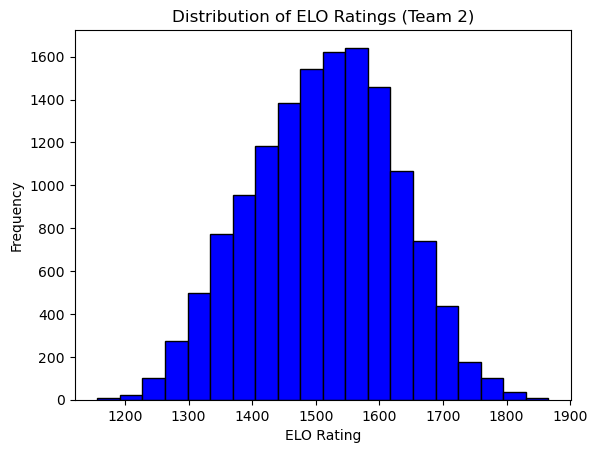

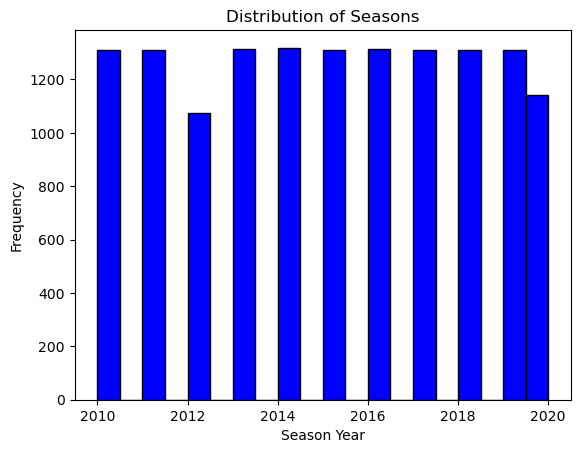

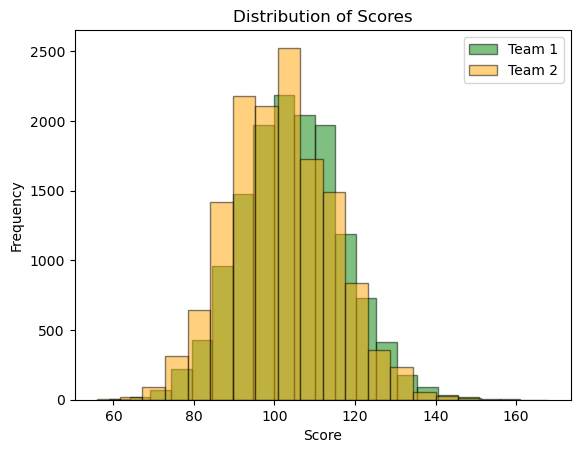

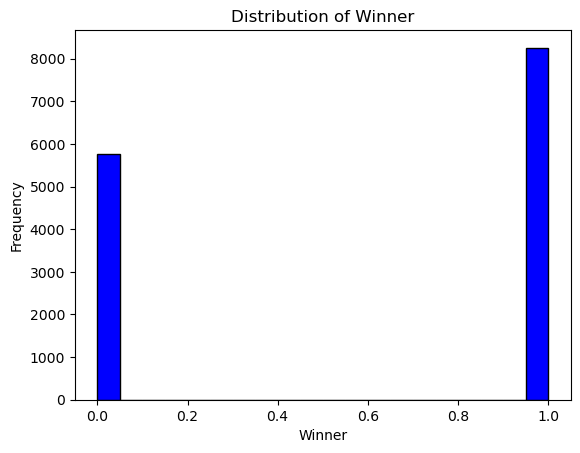

In [74]:
# Distribution of ELO ratings
plt.hist(small_train.get_column('elo1_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 1)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of ELO ratings
plt.hist(small_train.get_column('elo2_pre'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of ELO Ratings (Team 2)")
plt.xlabel("ELO Rating")
plt.ylabel("Frequency")
plt.show()

# Distribution of Seasons
plt.hist(small_train.get_column('season'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Seasons")
plt.xlabel("Season Year")
plt.ylabel("Frequency")
plt.show()

# Distribution of Scores
plt.hist(small_train.get_column('score1'), bins=20, alpha=0.5, label='Team 1', color='green', edgecolor='black')
plt.hist(small_train.get_column('score2'), bins=20, alpha=0.5, label='Team 2', color='orange', edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Distribution of Winner
plt.hist(small_train.get_column('winner'), bins=20, color='blue', edgecolor='black')
plt.title("Distribution of Winner")
plt.xlabel("Winner")
plt.ylabel("Frequency")
plt.show()




## Data Analysis
Here we can takeaway a few key aspects of the dataset. 
* Elo Ratings (Figure 1 and 2):
    * Despite all teams starting at 1300, we can see the median elo rating is around 1500, this indicates that on average teams were good and that very few teams were performing extremely poorly over time.
* Scores (Figure 4):
    * We can see that over the course of about 60 years, the average score of each team during a game was about 100.
* Winner (Figure 5):
    * This is the class we are trying to predict. We can see that there is some imbalance here as team1 tends to win more than team2. This indicates to us that the home team, which is the team presented first, won more often. This is actually a real phenomenon called "home court advantage"

## Preliminary Classifications

### Define X_train, y_train, X_text, y_test
Since winner, the class we are predicting, is the last column, we can easily split the datasets into X_train, y_train, X_test, and y_test.

In [75]:
# Define X_train, y_train, X_test, y_test
train_attributes = ['elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'team1', 'team2', 'score1','score2' ]

attribute_indexes = [small_train.column_names.index(attr) for attr in train_attributes]

X_train = [[row[index] for index in attribute_indexes] for row in small_train.data]
y_train = [row[-1] for row in small_train.data]

X_test = [[row[index] for index in attribute_indexes] for row in test.data]
y_test = [row[-1] for row in test.data]


### Dummy Classifier

In [76]:
importlib.reload(mysklearn.myevaluation)
dummy = MyDummyClassifier()
myevaluation.evaluate_classifier(dummy, X_train, y_train, X_test, y_test, "Dummy Classifier")


=== Dummy Classifier ===
Evaluation results for Dummy Classifier:
Accuracy: 0.43
Error Rate: 0.57
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 620], [0, 460]]


### Discretize and Preprocess Data
For the following classifiers we need to discretize the numerical data into categories.

In [77]:
importlib.reload(mysklearn.myutils)
X_train_discretized = myutils.preprocess_data(X_train)
X_test_discretized = myutils.preprocess_data(X_test)

### Naive Bayes Classifier

In [78]:
importlib.reload(mysklearn.myevaluation)
naive_bayes = MyNaiveBayesClassifier()
myevaluation.evaluate_classifier(naive_bayes, X_train_discretized, y_train, X_test_discretized, y_test, "Naive Bayes Classifier")


=== Naive Bayes Classifier ===
Evaluation results for Naive Bayes Classifier:
Accuracy: 0.58
Error Rate: 0.42
Precision: 0.68
Recall: 0.52
F1 Score: 0.59
Confusion Matrix:
[[320, 300], [154, 306]]


### Decision Trees Classifier

In [79]:
importlib.reload(mysklearn.myevaluation)
importlib.reload(mysklearn.myclassifiers)
dt = MyDecisionTreeClassifier()
dt.fit(X_train_discretized, y_train)
dt_pred = dt.predict(X_test_discretized)
myevaluation.accuracy_score(y_test, dt_pred)
myevaluation.evaluate_classifier(dt, X_train_discretized, y_train, X_test_discretized, y_test, "Decision Tree Classifier")


=== Decision Tree Classifier ===
Evaluation results for Decision Tree Classifier:
Accuracy: 0.43
Error Rate: 0.57
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 620], [0, 460]]


### Random Forest Classifiers

In [80]:
importlib.reload(mysklearn.myevaluation)
random_forest = MyRandomForestClassifier(n=10, m=8, f=2, M=5, random_state=42)
myevaluation.evaluate_classifier(random_forest, X_train, y_train, X_test, y_test, "Random Forest Classifier")


=== Random Forest Classifier ===
Evaluation results for Random Forest Classifier:
Accuracy: 0.43
Error Rate: 0.57
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0, 620], [0, 460]]


# Classification Results and Takeaways
In general, or classifiers performed poorly, we believe this is a result of poor implementation in combination with predicting an attribute that is fundamentally hard to predict using historical data. We used our own Dummy, Naive Bayes, Decision Tree and Random Forest classifiers implemented for the PA's and for this project. To evaluate and get performance statistics, we used a modified version of the classifier evaluation methods that was also implemented in a past PA. 

There are a few reasons that come to mind that explain why our classifiers generally scored very low accuracy ratings.
* There are many cases in basketball, and sports in general, where the team that is considered "worse" or the "underdog" ends up winning, even if they are statistically worse on paper.
* There are a few fundamental flaws with training with past data in sports.
    * The statistics in this dataset do not account for any trades. roster changes, or injuries throughout the seasons. This drastically impacts a teams performance.
    * Team staff, coaching, rules, and officials change over time. This is also not reflected in the dataset, so in general its hard to say that past trends of games between two teams are meaningful in the future.
    * Past performance doesn't necessarily correlate to future success due to changing rosters, rules, coaching, and culture within the NBA
* Similarly, this data cannot account for players and teams outperforming or under-performing their "skill rating" or elo. Athletes performances will naturally vary throughout the season.
* Classifiers and models cannot account for the intangible qualities of sports and athletes.

Considering these flaws, I'm surprised that we were even able to achieve about 58% accuracy with Naive Bayes. Since the attribute we were predicting was binary, it performed better than a coin flip but not well enough to be relied on for any meaningful conclusions. If we were to approach this project again, I would consider looking into other classes to predict on. If we could find the finances of each of the teams, maybe we could find some way to predict performance or elo rating based on the amount of money each team spent. But this could also run into some of the issues that are associated with analyzing trends in the sports field and trying to extrapolate that onto future events.
    

# Acknowledgements
### Sources:
Dataset: https://www.kaggle.com/datasets/tunguz/nba-forecasts

Since the dataset lacked documentation, we utilized ChatGPT to help analyze the dataset in order help us understand the attributes in the dataset. 